# *Entregable 2 Deep Learning: Redes Convolucionales*
- Rubén Gil Martínez

# **P2.1**

**E1:** Carga las imágenes de entrada y sus identificadores de clase correspondientes. Almacénalos en dos tensores con las dimensiones adecuadas para servir de entrada y salida (entrenamiento) respectivamente de la red neuronal construida.

**E2:** Aleatoriza la posición de las imágenes y consecuentemente los identificadores.

**E3:** Particiona los tensores de entrada en dos, asigna el 80% de las imágenes para el entrenamiento y el 20% para la validación.


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, optimizers
import os
from keras.preprocessing.image import load_img, img_to_array

In [ ]:
# Ruta del conjunto de datos
data_path = '../data/imgs/SNR_high'

# Dimensiones de las imágenes
img_size = (50, 50)

# Cargar imágenes y etiquetas
images = []
labels = []

for filename in os.listdir(data_path):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        # Extraer la etiqueta del nombre del archivo
        label = str(filename.split('_')[0])  
        
        # Cargar imagen en escala de grises
        img_path = os.path.join(data_path, filename)
        image = load_img(img_path, color_mode='grayscale', target_size=img_size)
        image = img_to_array(image) / 255.0  # Normalizar los valores de los píxeles
        
        images.append(image)
        labels.append(label)


# Codificar las etiquetas para que sean números enteros, importante ya que la red neuronal solo acepta números
labels = LabelEncoder().fit_transform(labels) 

# Convertir listas a arreglos numpy
images = np.array(images , dtype= np.float32)  
labels = np.array(labels, dtype= np.int32)

# Aleatorizamos la posición de las imágenes y etiquetas con la herramienta shuffle de sklearn para evitar sesgos
images , labels = shuffle(images, labels, random_state=2025)

# Partición en entrenamiento (80%) y validación (20%)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=2025)

# Imprimir dimensiones resultantes
print("Tamaño del conjunto de entrenamiento: Datos:", X_train.shape, "Etiquetas:", y_train.shape)
print("Tamaño del conjunto de validación: Datos:", X_val.shape, "Etiquetas:", y_val.shape)


Tamaño del conjunto de entrenamiento: Datos: (400, 50, 50, 1) Etiquetas: (400,)
Tamaño del conjunto de validación: Datos: (100, 50, 50, 1) (100,)


**E4:** Construye un MLP que realice la clasificación de las imágenes según se especifica en el apartado [MLP baseline](mlp). Utiliza el algoritmo de optimización y la función de pérdidas que creas más oportuna.

**Utilizamos Adam como algoritmo de optimizción adaptativo, varía el tamaño del learning en función de lo cerca/lejos que nos encontremos del mínimo global y como función de pérdidas se emplea sparse_categorical_crossentropy ya que estamos ante un problema de clasificación multiclase.**

**E5:** ¿Cuántos parámetros a entrenar tendría esta red?
**Contiene 1,453,317 de parámetros entrenables debido a las múltiples conexiones entre todas las neuronas.**

**E6:** Entrena el modelo y encuentra la combinación de tamaño de batch y épocas que genere mejores resultados.

**Tras varios entrenamientos, encontramos la combinación de 200 épocas y tamaño de batch 64 como la mejor opción en cuanto a resultados.**

In [17]:
# Definimos un earling stop para detener el entrenamiento de los modelos cuando ya no mejoren la precisión de la validación
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Métrica a monitorear 
    patience=40,  # Número de epochs sin mejora antes de parar
    min_delta=0.001,  # Pequeña mejora mínima requerida
    restore_best_weights=True,  # Restaura los mejores pesos en lugar de los últimos
    verbose=1  # Muestra mensaje en la consola con la época que contiene los mejores pesos
)

In [6]:
model = Sequential([ 
    layers.Input(shape=(2500,)),
    layers.Dense(512, activation='leaky_relu'),
    layers.Dense(256, activation='leaky_relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     1,280,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,453,317 (5.54 MB)

 Trainable params: 1,453,317 (5.54 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Aplanamos las imágenes para que puedan ser procesadas por la red
X_train_MLP = X_train.reshape(X_train.shape[0], 2500, 1)
X_val_MLP = X_val.reshape(X_val.shape[0], 2500, 1)

In [8]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_MLP, y_train, epochs=150, batch_size=32, validation_data=(X_val_MLP, y_val), callbacks=[early_stopping])

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1437 - loss: 2.5047 - val_accuracy: 0.2200 - val_loss: 2.1576
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2161 - loss: 1.9565 - val_accuracy: 0.3000 - val_loss: 1.7439
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2627 - loss: 1.7199 - val_accuracy: 0.2600 - val_loss: 1.7695
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2541 - loss: 1.8090 - val_accuracy: 0.2000 - val_loss: 1.7283
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2285 - loss: 1.6439 - val_accuracy: 0.2500 - val_loss: 1.5244
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3949 - loss: 1.4591 - val_accuracy: 0.2100 - val_loss: 1.5611
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4236 - loss: 1.3846 - val_accuracy: 0.4200 - val_loss: 1.4411
Epoch 8/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3845 - loss: 1.3485 - val_accuracy: 0.48

**E7:** Muestra la evolución de la función de pérdidas para los conjuntos de datos de entrenamiento y validación a lo largo del proceso de entrenamiento.

**E8:** ¿Qué precisión tiene el modelo?

In [10]:
# Suponiendo que usaste EarlyStopping como callback
best_epoch = early_stopping.best_epoch
print(f"La mejor época según EarlyStopping fue la {best_epoch}")


La mejor época según EarlyStopping fue la 105


Text(0.5, 1.0, 'Evolución de la función de pérdida a lo largo del entrenamiento')

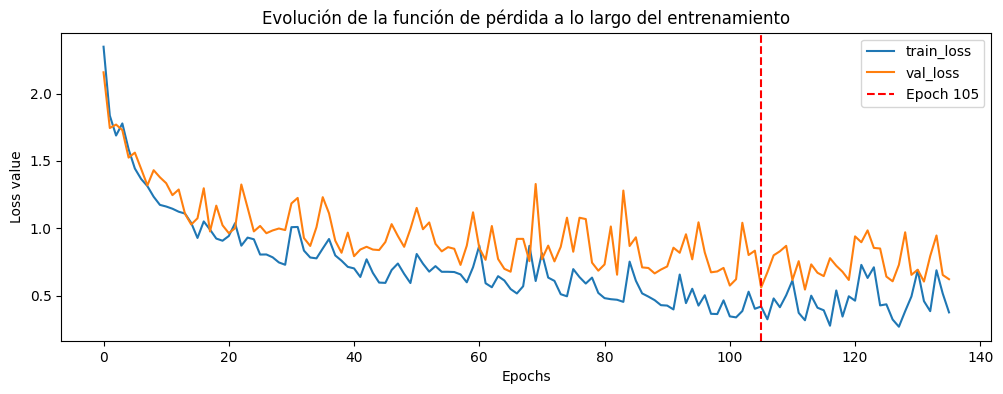

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
# Línea vertical en la época 22
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Epoch {best_epoch}')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.title('Evolución de la función de pérdida a lo largo del entrenamiento')

In [12]:
# Evaluar el modelo en el conjunto de validación
_, accuracy = model.evaluate(X_val_MLP, y_val)
print(f"Precisión en datos de validación: {accuracy:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8424 - loss: 0.5177 
Precisión en datos de validación: 0.83


In [13]:
# Podemos observar este mismo dato en el historial de entrenamiento, último valor de la exactitud en el conjunto de validación.
print(f"Exactitud del modelo con datos de entrenamiento: ", history.history['accuracy'][best_epoch], f" \n Exactitud del modelo con datos de validación: ", history.history['val_accuracy'][best_epoch])

Exactitud del modelo con datos de entrenamiento:  0.8525000214576721  
 Exactitud del modelo con datos de validación:  0.8299999833106995


**E9:** Construye una red neuronal para clasificar las imágenes del dataset que contenga capas convolucionales y un MLP. Utiliza el algoritmo de optimización y la función de pérdidas que creas más oportuna.

**E10:** ¿Cuántos parámetros a entrenar tendría esta red? Compáralos con los que se obtuvieron con el MLP.
**Esta red, por la arquitectura que he decidido tomar, 3 capas convolucionales, 2 capas de MaxPooling y una red final Fully Conected(FC) con una capa oculta, contiene 716,485 parámetros entrenables, bastantes menos que los utilizados en la arquitectura MLP. Esto se da porque, en esta arquitectura, los pesos son los coeficientes de los filtros y esos pesos son aplicados a todos los datos(píxeles) de la imagen de entrada. Sin embargo, en MLP se utilizan pesos específicos para tratar cada dato/píxel de entrada, de ahí viene la disminución de la cantidad de parámetros a entrenar.**

**E11:** Entrena el modelo y determina la precisión de la clasificación. Discute los resultados en comparación con los que se obtuvieron con el MLP

**Pues podemos observar que con una red convolucional se consiguen mejores resultados cuando tratamos con imágenes, es una arquitectura que esta diseñada específicamente para tratar con estas y poder aprender todas sus características, por otro lado, el MLP es mucho más general ya que NO consigue mantener la importante información espacial que llevan intrínseca las imágenes.**

In [14]:
CNN_model = Sequential([
    layers.Input(shape=(50, 50, 1)),  # Escala de grises

    layers.Conv2D(32, (3, 3), strides=(1, 1), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (5, 5), strides=(2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # Capa de salida
])

CNN_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 716,933 (2.73 MB)

 Trainable params: 716,485 (2.73 MB)

 Non-trainable params: 448 (1.75 KB)

In [18]:
CNN_model.compile((optimizers.Adagrad(learning_rate=0.01)), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

CNN_model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7228 - loss: 0.6407 - val_accuracy: 0.3800 - val_loss: 1.5677
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7922 - loss: 0.5013 - val_accuracy: 0.2200 - val_loss: 1.5797
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8516 - loss: 0.4083 - val_accuracy: 0.2200 - val_loss: 1.5613
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9044 - loss: 0.3206 - val_accuracy: 0.2200 - val_loss: 1.5711
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9065 - loss: 0.2561 - val_accuracy: 0.2200 - val_loss: 1.5917
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8865 - loss: 0.3014 - val_accuracy: 0.2200 - val_loss: 1.6041
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9116 - loss: 0.2205 - val_accuracy: 0.2200 - val_loss: 1.6078
Epoch 8/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8463 - loss: 0.3309 - val_accuracy: 0.

In [19]:
_, accuracy = CNN_model.evaluate(X_val, y_val)
print(f"Precisión en datos de validación: {accuracy:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9234 - loss: 0.4533 
Precisión en datos de validación: 0.91


**E12:** Muestra la matriz de confusión resultado de procesar el conjunto de datos de test.

**E13:** ¿Qué dos clases presentan mayor confusión mutua? ¿Por qué? Visualiza unas cuantas imágenes con clasificaciones correctas e incorrectas.
**Las clases que presentan mayor confusión mutua son 6utj con 3j9i y 4cr2 con 4v94  debido a que tiene una estructura, intensidad y forma parecidas.**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


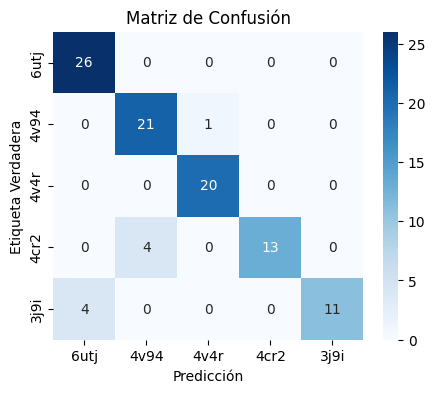

              precision    recall  f1-score   support

        6utj       0.87      1.00      0.93        26
        4v94       0.84      0.95      0.89        22
        4v4r       0.95      1.00      0.98        20
        4cr2       1.00      0.76      0.87        17
        3j9i       1.00      0.73      0.85        15

    accuracy                           0.91       100
   macro avg       0.93      0.89      0.90       100
weighted avg       0.92      0.91      0.91       100



In [ ]:
class_names = ['6utj', '4v94', '4v4r', '4cr2', '3j9i']
# Predicciones
y_pred = np.argmax(CNN_model.predict(X_val), axis=-1)

# Matriz de confusión
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.show()

# Reporte de métricas
print(classification_report(y_val, y_pred, target_names=class_names))


**Visualización de imágenes de ejemplo: Podemos observar como hay cierto parecido en las intensidades de las escalas de grises y la forma de las proteinas lo que puede llevar a la confusión a nuestra red a la hora de clasificar una y otra clase.**

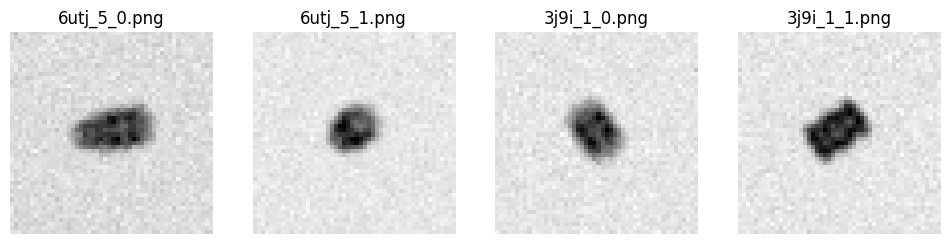

In [21]:
seis_utj_1 = load_img('../data/imgs/SNR_high/6utj_5_0.png', color_mode='grayscale', target_size=img_size)
seis_utj_2 = load_img('../data/imgs/SNR_high/6utj_5_1.png', color_mode='grayscale', target_size=img_size)
tres_j9i_1 = load_img('../data/imgs/SNR_high/3j9i_1_0.png', color_mode='grayscale', target_size=img_size)
tres_j9i_2 = load_img('../data/imgs/SNR_high/3j9i_1_1.png', color_mode='grayscale', target_size=img_size)

plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.imshow(seis_utj_1, cmap='gray')
plt.axis('off')
plt.title('6utj_5_0.png')
plt.subplot(1, 4, 2)
plt.imshow(seis_utj_2, cmap='gray')
plt.axis('off')
plt.title('6utj_5_1.png')
plt.subplot(1, 4, 3)
plt.imshow(tres_j9i_1, cmap='gray')
plt.axis('off')
plt.title('3j9i_1_0.png')
plt.subplot(1, 4, 4)
plt.imshow(tres_j9i_2, cmap='gray')
plt.axis('off')
plt.title('3j9i_1_1.png')
plt.show()


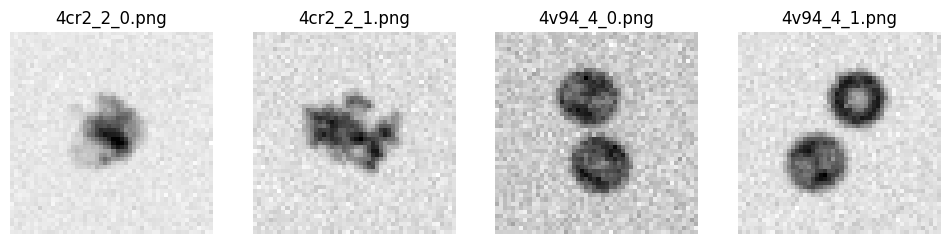

In [22]:
seis_utj_1 = load_img('../data/imgs/SNR_high/4cr2_2_0.png', color_mode='grayscale', target_size=img_size)
seis_utj_2 = load_img('../data/imgs/SNR_high/4cr2_2_1.png', color_mode='grayscale', target_size=img_size)
tres_j9i_1 = load_img('../data/imgs/SNR_high/4v94_4_0.png', color_mode='grayscale', target_size=img_size)
tres_j9i_2 = load_img('../data/imgs/SNR_high/4v94_4_1.png', color_mode='grayscale', target_size=img_size)

plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.imshow(seis_utj_1, cmap='gray')
plt.axis('off')
plt.title('4cr2_2_0.png')
plt.subplot(1, 4, 2)
plt.imshow(seis_utj_2, cmap='gray')
plt.axis('off')
plt.title('4cr2_2_1.png')
plt.subplot(1, 4, 3)
plt.imshow(tres_j9i_1, cmap='gray')
plt.axis('off')
plt.title('4v94_4_0.png')
plt.subplot(1, 4, 4)
plt.imshow(tres_j9i_2, cmap='gray')
plt.axis('off')
plt.title('4v94_4_1.png')
plt.show()


# **P2.2**

**E1:** Carga las imágenes de entrada del directorio y preprocésalas según se especifica en la sección [El dataset](#dataset). Almacénalas en tensores con las dimensiones adecuadas para servir de entrada y/o salida una red U-Net.

**E2:** Aleatoriza la posicion de las imágenes y consecuentemente los identificadores.

**E3:** Particiona los tensores de entrada en dos, asigna el 80% de las imágenes para el entrenamiento y el 20% para la validación.

In [2]:
import mrcfile

def load_mrc(fname, mmap=False, no_saxes=True):
    """
    Load an input MRC tomogram as ndarray
    :param fname: the input MRC
    :param mmap: if True (default False) the data are read as a memory map
    :param no_saxes: if True (default) then X and Y axes are swapped to cancel the swapping made by mrcfile package
    :return: a ndarray (or memmap if mmap=True)
    """
    if mmap:
        mrc = mrcfile.mmap(fname, permissive=True, mode='r+')
    else:
        mrc = mrcfile.open(fname, permissive=True, mode='r+')
    if no_saxes:
        return np.swapaxes(mrc.data, 0, 2)
    return mrc.data


def center_crop(image, size=56):
    """
    Crop the center of the image to the desired size.
    """
    h, w, _ = image.shape
    start_h = (h - size) // 2
    start_w = (w - size) // 2
    return image[start_h:start_h + size, start_w:start_w + size]


def load_dataset(noisy_path, clean_path, size=56):
    """
    Load MRC images from directories and preprocess them.
    :param noisy_path: Path to noisy images
    :param clean_path: Path to clean images
    :param size: Target crop size
    :return: Tuple of numpy arrays (noisy_images, clean_images)
    """
    print("Loading dataset...")
    noisy_images, clean_images = [], []
    
    noisy_files = sorted(os.listdir(noisy_path))
    clean_files = sorted(os.listdir(clean_path))
    
    for noisy_file, clean_file in zip(noisy_files, clean_files):
        if noisy_file.endswith('.mrc') and clean_file.endswith('.mrc'):
            noisy_img = load_mrc(os.path.join(noisy_path, noisy_file))
            clean_img = load_mrc(os.path.join(clean_path, clean_file))
            
            noisy_img = center_crop(noisy_img, size)
            clean_img = center_crop(clean_img, size)
            
            noisy_images.append(noisy_img.astype(np.float32))
            clean_images.append(clean_img.astype(np.float32))
    print("Dataset loaded.")
    
    return np.array(noisy_images), np.array(clean_images)

In [3]:
# Cargar el conjunto de datos
noisy_dir = "../data/SNR_low/noisy"
clean_dir = "../data/SNR_low/clean"
noisy_dataset, clean_dataset = load_dataset(noisy_dir, clean_dir)

Loading dataset...
Dataset loaded.


In [ ]:
# Normalizamos los valores de los píxeles entre -1 y 1
X = noisy_dataset / noisy_dataset.max()
Y = clean_dataset / clean_dataset.max()

# Aleatorizamos la posición de las imágenes mediante la función shuffle de sklearn
X, Y = shuffle(X, Y, random_state=2025)

# Partición en entrenamiento (80%) y validación (20%)
x_t, x_v, y_t, y_v = train_test_split(X, Y, test_size=0.2, random_state=2025)

# Imprimir dimensiones resultantes
print("Tamaño del conjunto de entrenamiento: Ruidosas:", x_t.shape, "Objetivo:", y_t.shape)
print("Tamaño del conjunto de validación: Ruidosas:", x_v.shape, "Objetivo:", y_v.shape)

Tamaño del conjunto de entrenamiento: Ruidosas: (400, 56, 56, 1) Objetivo: (400, 56, 56, 1)
Tamaño del conjunto de validación: Ruidosas: (100, 56, 56, 1) Objetivo: (100, 56, 56, 1)


**E4:** Adapta la arquitectura mostrada en la sección [Restauración de imágenes](#restauracion) red para resolver la tarea de restauración de las imágenes cargadas en el ejercicio anterior.

**E5:** Entrénala teniendo en cuenta la función de perdidas que mejor se ajusta al problema de restauración propuesto. Fija unos parámetros que te permitan conseguir sobreajuste.

**Utilizamos como métricas mae y mse ya que el objetivo será que el valor de los píxeles de la imagen generada sea lo más cercano posible al valor real del correspondiente píxel en la imagen real/limpia, por otro lado, fijaremos 50 épocas de entrenamiento con lotes de tamaño 64 para conducir a la red al sobreajuste.**

**Observaremos qué tal se comporta mostrando algunas imágenes de las restauraciones realizadas por ella.**

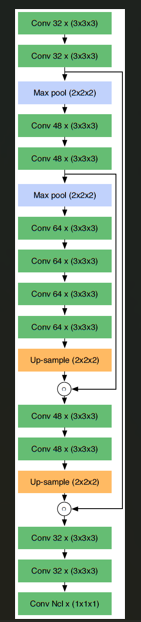 **Arquitectura desarrollada por DeepFinder que trataremos de adaptar para la restauración de nuestras imágenes de microscopía.**


In [97]:
# Creación arquitecura U-Net
def architecture_u_net_2d(input_shape=(56, 56, 1)):
    inputs = layers.Input(shape=input_shape)

    # Down-sampling
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)

    # Up-sampling
    u1 = layers.UpSampling2D((2, 2))(c3)
    u1 = layers.Concatenate()([u1, c2])  # Skip connection
    u1 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(u1)
    

    u2 = layers.UpSampling2D((2, 2))(u1)
    u2 = layers.Concatenate()([u2, c1])  # Skip connection
    u2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)

    # Salida
    outputs = layers.Conv2D(1, (1, 1), activation='tanh', padding='same')(u2) # Utilizamos la función de activación tangente hiperbólica para que los valores estén entre -1 y 1

    return keras.Model(inputs, outputs)

# Crear modelo
u_net_model = architecture_u_net_2d()

# Resumen del modelo
u_net_model.summary()


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 56, 56, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_195 (Conv2D) │ (None, 56, 56,    │        320 │ input_layer_15[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_196 (Conv2D) │ (None, 56, 56,    │      9,248 │ conv2d_195[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 28, 28,    │          0 │ conv2d_196[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_197 (Conv2D) │ (None, 28, 28,    │     13,872 │ max_pooling2d_30… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_198 (Conv2D) │ (None, 28, 28,    │     20,784 │ conv2d_197[0][0]  │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 14, 14,    │          0 │ conv2d_198[0][0]  │
│ (MaxPooling2D)      │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_199 (Conv2D) │ (None, 14, 14,    │     27,712 │ max_pooling2d_31… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_200 (Conv2D) │ (None, 14, 14,    │     36,928 │ conv2d_199[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_201 (Conv2D) │ (None, 14, 14,    │     36,928 │ conv2d_200[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_202 (Conv2D) │ (None, 14, 14,    │     36,928 │ conv2d_201[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_30    │ (None, 28, 28,    │          0 │ conv2d_202[0][0]  │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_30      │ (None, 28, 28,    │          0 │ up_sampling2d_30… │
│ (Concatenate)       │ 112)              │            │ conv2d_198[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_203 (Conv2D) │ (None, 28, 28,    │     48,432 │ concatenate_30[0… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_204 (Conv2D) │ (None, 28, 28,    │     20,784 │ conv2d_203[0][0]  │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_31    │ (None, 56, 56,    │          0 │ conv2d_204[0][0]  │
│ (UpSampling2D)      │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_31      │ (None, 56, 56,    │          0 │ up_sampling2d_31

 Total params: 284,289 (1.08 MB)

 Trainable params: 284,289 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

**Para inducir al sobreajuste de la red haremos lo siguiente:**
1) No aplicaremos técnicas de regularización 
2) Tasa de aprendizaje alta
3) Muchas épocas 

In [87]:
# Compilamos el modelo: Utilizamos como métricas mae y mse ya que el objetivo será que el valor de los píxeles de la imagen generada sea lo 
# más cercano posible al valor real del correspondiente píxel en la imagen real.
u_net_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse', metrics=['mae'])


# Entrenamos el modelo: Utilizamos 150 épocas y un tamaño de lote de 16 para abocar al modelo al sobreajuste.
history = u_net_model.fit(x_t, y_t, epochs=150, batch_size=16, validation_data=(x_v, y_v))

Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0116 - mae: 0.0486 - val_loss: 0.0105 - val_mae: 0.0533
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0107 - mae: 0.0556 - val_loss: 0.0188 - val_mae: 0.0746
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0113 - mae: 0.0602 - val_loss: 0.0084 - val_mae: 0.0458
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0075 - mae: 0.0402 - val_loss: 0.0045 - val_mae: 0.0234
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0076 - mae: 0.0354 - val_loss: 0.0069 - val_mae: 0.0306
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0062 - mae: 0.0319 - val_loss: 0.0036 - val_mae: 0.0184
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0039 - mae: 0.0219 - val_loss: 0.0044 - val_mae: 0.0209
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0038 - mae: 0.0204 - val_loss: 0.0032 - val_mae: 0.0218
Epoch 9/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - lo

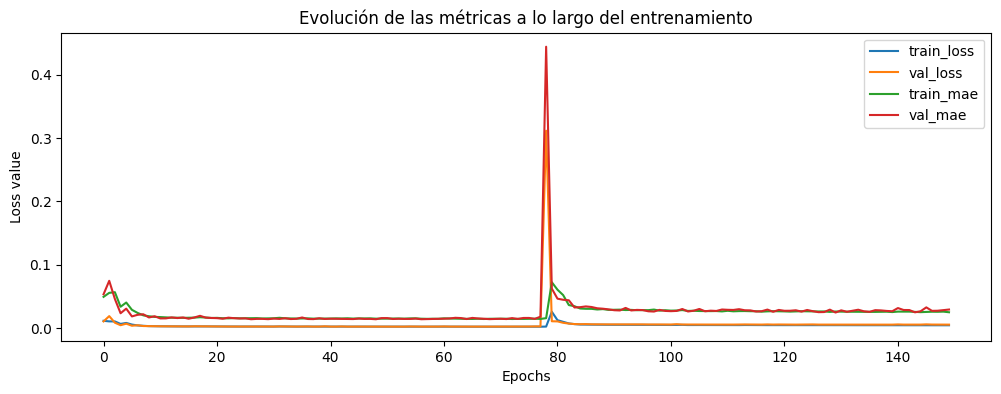

In [90]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.title('Evolución de las métricas a lo largo del entrenamiento')
plt.show()

**E6:** Visualiza algunos ejemplos de imágenes restauradas comparadas con las imágenes de partida y las imágenes sin distorsiones. ¿Se consigue eliminar el ruido? ¿Se consigue restaurar perfectamente la estructura de la molécula original?

**Aparentemente se consigue eliminar el ruido intenso que contienen las imágenes de entrada pero aprece cierto ruido en la salida debido a que la red identifica patrones donde realmente no hay nada. Se consigue restaurar una parte importante de la estructura de las moléculas pero, observando la gráfica, podemos ver que el modelo está sobreentrenado(claramente se ve en las oscilaciones y cambio de escalón de val_mae).**

In [88]:
images_to_restore = x_v[:4]
restored_images = u_net_model.predict(images_to_restore)
real_images = y_v[:4]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


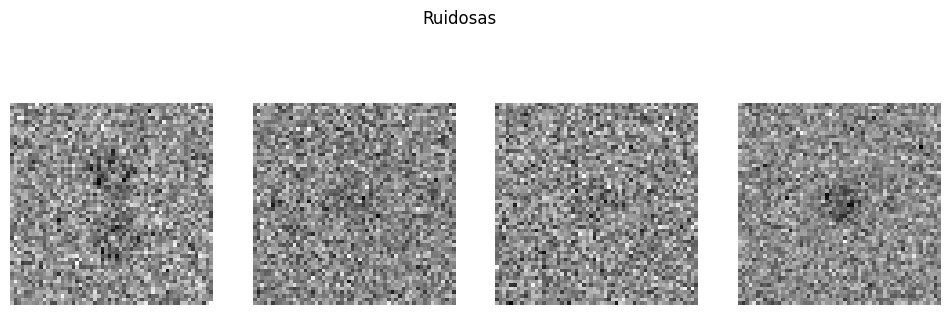

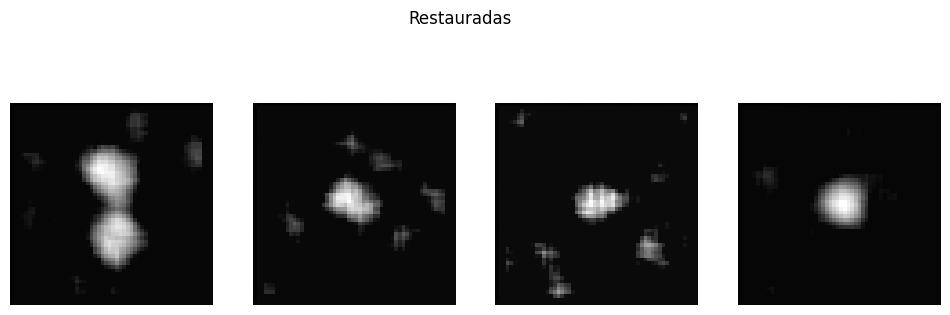

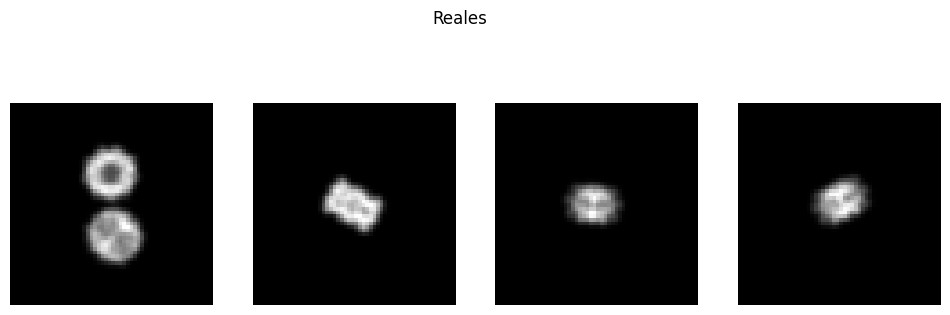

In [89]:

plt.figure(figsize=(12, 4))
plt.suptitle('Ruidosas')
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images_to_restore[i].reshape(56, 56), cmap='gray')
    plt.axis('off')

plt.figure(figsize=(12, 4))
plt.suptitle('Restauradas')
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(restored_images[i].reshape(56, 56), cmap='gray')
    plt.axis('off')

plt.figure(figsize=(12, 4))
plt.suptitle('Reales')
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(real_images[i].reshape(56, 56), cmap='gray')
    plt.axis('off')



## **Pasemos ahora a realizar el entrenamiento de esta correctamente para no caer en el sobreajuste y conseguir así un buen resultado de restauración de las imágenes:**



**E7:** Repite los ejercicios E5 e E6 pero añadiendo unos mecanismos de parada temprana para evitar la aparición de sobre ajuste. ¿Cuánto dura ahora el entrenamiento? ¿Se ha conseguido un mejor resultado? ¿Por qué?

**Ahora el entrenamiento dura bastante menos ya que es finalizado cuando se observa que la función de pérdidas de validación no decrece o crece, esto se consigue gracias al Early Stopping definido.**
**Por supuesto que se consigue un mejor resultado, porque ahora si estamos tratando de evitar el sobreajuste del modelo consiguiendo así una buena generalización en su comportamiento ante nuevas imágenes.**

In [98]:
# Crear modelo
u_net_model_best = architecture_u_net_2d()

# Resumen del modelo
u_net_model_best.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 56, 56, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_208 (Conv2D) │ (None, 56, 56,    │        320 │ input_layer_16[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_209 (Conv2D) │ (None, 56, 56,    │      9,248 │ conv2d_208[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 28, 28,    │          0 │ conv2d_209[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_210 (Conv2D) │ (None, 28, 28,    │     13,872 │ max_pooling2d_32… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_211 (Conv2D) │ (None, 28, 28,    │     20,784 │ conv2d_210[0][0]  │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_33    │ (None, 14, 14,    │          0 │ conv2d_211[0][0]  │
│ (MaxPooling2D)      │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_212 (Conv2D) │ (None, 14, 14,    │     27,712 │ max_pooling2d_33… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_213 (Conv2D) │ (None, 14, 14,    │     36,928 │ conv2d_212[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_214 (Conv2D) │ (None, 14, 14,    │     36,928 │ conv2d_213[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_215 (Conv2D) │ (None, 14, 14,    │     36,928 │ conv2d_214[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_32    │ (None, 28, 28,    │          0 │ conv2d_215[0][0]  │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_32      │ (None, 28, 28,    │          0 │ up_sampling2d_32… │
│ (Concatenate)       │ 112)              │            │ conv2d_211[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_216 (Conv2D) │ (None, 28, 28,    │     48,432 │ concatenate_32[0… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_217 (Conv2D) │ (None, 28, 28,    │     20,784 │ conv2d_216[0][0]  │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_33    │ (None, 56, 56,    │          0 │ conv2d_217[0][0]  │
│ (UpSampling2D)      │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_33      │ (None, 56, 56,    │          0 │ up_sampling2d_33

 Total params: 284,289 (1.08 MB)

 Trainable params: 284,289 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

**Early Stopping**

In [99]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_mae',  # Métrica a monitorear 
    patience=50,  # Número de epochs sin mejora antes de parar
    min_delta=0.00001,  # Pequeña mejora mínima requerida
    restore_best_weights=True,  # Restaura los mejores pesos en lugar de los últimos
    verbose=1  # Muestra mensaje en la consola con la época que contiene los mejores pesos
)

In [ ]:
# Compilamos el modelo con un learning rate de inicial correcto para conseguir un aprendizaje progresivo
u_net_model_best.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])


# Entrenamos el modelo: Utilizamos 150 épocas, un tamaño de lote de 16 y definimos un Early Stopping para parar el entrenamiento en caso de indicio de sobreajuste.
history = u_net_model_best.fit(x_t, y_t, epochs=150, batch_size=16, validation_data=(x_v, y_v), callbacks=[early_stopping])

Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0107 - mae: 0.0476 - val_loss: 0.0100 - val_mae: 0.0664
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0090 - mae: 0.0478 - val_loss: 0.0055 - val_mae: 0.0369
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0040 - mae: 0.0230 - val_loss: 0.0033 - val_mae: 0.0210
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0028 - mae: 0.0184 - val_loss: 0.0026 - val_mae: 0.0170
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0024 - mae: 0.0157 - val_loss: 0.0024 - val_mae: 0.0168
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0022 - mae: 0.0155 - val_loss: 0.0023 - val_mae: 0.0159
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0024 - mae: 0.0156 - val_loss: 0.0023 - val_mae: 0.0154
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0024 - mae: 0.0154 - val_loss: 0.0028 - val_mae: 0.0168
Epoch 9/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - lo

In [101]:
images_to_restore = x_v[:4]
restored_images = u_net_model_best.predict(images_to_restore)
real_images = y_v[:4]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


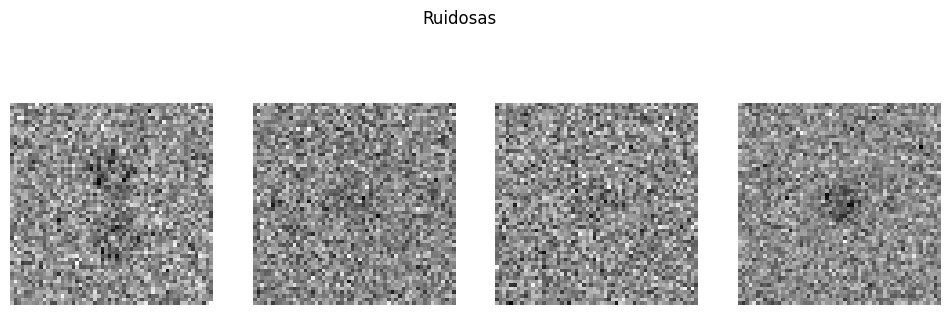

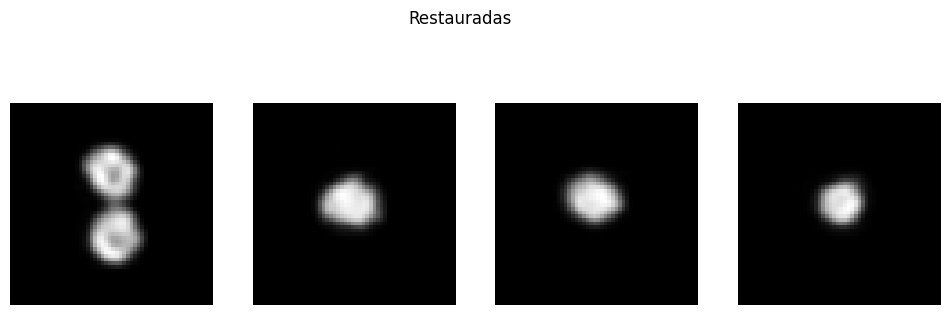

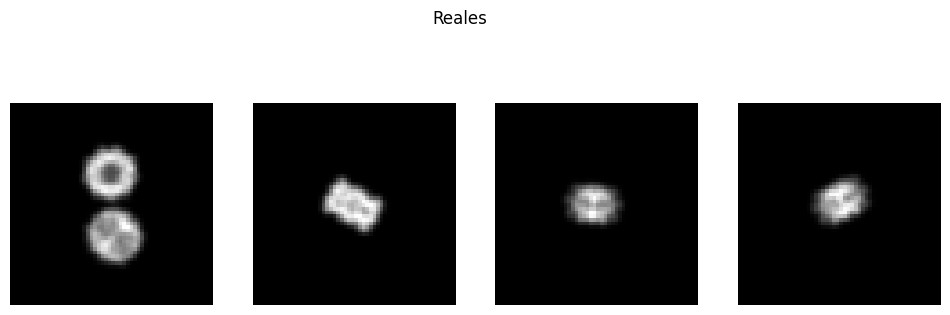

In [102]:
plt.figure(figsize=(12, 4))
plt.suptitle('Ruidosas')
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images_to_restore[i].reshape(56, 56), cmap='gray')
    plt.axis('off')

plt.figure(figsize=(12, 4))
plt.suptitle('Restauradas')
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(restored_images[i].reshape(56, 56), cmap='gray')
    plt.axis('off')

plt.figure(figsize=(12, 4))
plt.suptitle('Reales')
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(real_images[i].reshape(56, 56), cmap='gray')
    plt.axis('off')

# **P2.3**